In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

In [4]:
os.getcwd()

'/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/notebooks'

In [5]:
local_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/energy_generation_data'

In [6]:
for path, dirs, files in os.walk(local_path):
    print(path)
    for f in files:
        print(f)

In [7]:
daily_data_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/Daily/energy_generation_data/df_deutschland.csv'
hourly_data_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv'

## Importing target

In [8]:
daily_df = pd.read_csv(daily_data_path)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df.set_index('Date', inplace=True)

daily_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
Date,,,,
2015-01-01,11.989583,1278.427083,75.531250,50hertz
2015-01-02,9.947917,2555.510417,17.677083,50hertz
2015-01-03,11.281250,2308.958333,27.354167,50hertz
2015-01-04,11.354167,2079.041667,49.750000,50hertz
2015-01-05,4.104167,1333.343750,20.187500,50hertz


In [9]:
hourly_df = pd.read_csv(hourly_data_path)

hourly_df['Date'] = pd.to_datetime(hourly_df['Date'])
hourly_df.set_index('Date', inplace=True)

hourly_df.tail()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
Date,,,,
2021-01-01 19:00:00,0.0,13.0,0.0,transnet_bw
2021-01-01 20:00:00,0.0,21.0,0.0,transnet_bw
2021-01-01 21:00:00,0.0,18.0,0.0,transnet_bw
2021-01-01 22:00:00,0.0,25.0,0.0,transnet_bw
2021-01-01 23:00:00,0.0,29.0,0.0,transnet_bw


In [10]:
hourly_de_df = hourly_df.groupby(hourly_df.index).sum()
hourly_de_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0
2015-01-01 03:00:00,519.0,8552.0,0.0
2015-01-01 04:00:00,522.0,8646.0,0.0


In [14]:
hourly_pv_de_df = pd.DataFrame(hourly_de_df['Photovoltaics[MWh]'])
hourly_pv_de_df.head()

,Photovoltaics[MWh]
Date,
2015-01-01 00:00:00,0.0
2015-01-01 01:00:00,0.0
2015-01-01 02:00:00,0.0
2015-01-01 03:00:00,0.0
2015-01-01 04:00:00,0.0


In [15]:
hourly_pv_de_df.tail()

,Photovoltaics[MWh]
Date,
2021-01-01 19:00:00,0.0
2021-01-01 20:00:00,0.0
2021-01-01 21:00:00,0.0
2021-01-01 22:00:00,0.0
2021-01-01 23:00:00,0.0


## Importing features

In [19]:
feature_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Features/DATAFRAMES'

In [103]:
def clean_dataframe(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    if df.dtypes[0] == 'float64':
        df = df.astype('float32')
    if df.dtypes[0] == 'int64':
        df = df.astype('int32')
    return df

In [67]:
for path, dirs, files in os.walk(feature_path):
    print(path)
    for f in files:
        if f.startswith('hourly'):
                print(f.strip('.csv'))

/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Features/DATAFRAMES
hourly_globalradiation_df
hourly_humidity_df
hourly_directradiation_df
hourly_cloud_df
hourly_airp_df
hourly_temperature_df


In [34]:
for path, dirs, files in os.walk(feature_path):
    for f in files:
        if f.startswith('hourly'):
            print(f.strip('.csv'))
#            exec('df = f.strip(".csv")')
            exec(f"df_{f.strip('.csv')} = pd.read_csv(os.path.join(feature_path,{f}))")

hourly_globalradiation_df


NameError: name 'hourly_globalradiation_df' is not defined

In [104]:
hourly_globalradiation_df = clean_dataframe(pd.read_csv(os.path.join(feature_path,'hourly_globalradiation_df.csv')))

In [109]:
hourly_humidity_df = clean_dataframe(pd.read_csv(os.path.join(feature_path,'hourly_humidity_df.csv')))
hourly_directradiation_df = clean_dataframe(pd.read_csv(os.path.join(feature_path,'hourly_directradiation_df.csv')))
hourly_cloud_df = clean_dataframe(pd.read_csv(os.path.join(feature_path,'hourly_cloud_df.csv')))
hourly_airp_df = clean_dataframe(pd.read_csv(os.path.join(feature_path,'hourly_airp_df.csv')))
hourly_temperature_df = clean_dataframe(pd.read_csv(os.path.join(feature_path,'hourly_temperature_df.csv')))

In [110]:
hourly_temperature_df.head()

,44,71,73,78,91,96,102,125,131,142,...,13711,13713,13777,13965,15000,15207,15444,15555,19171,19172
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2.2,-3.7,-2.1,1.6,0.6,NaN,3.9,-9.6,1.1,-1.7,...,1.9,1.1,4.2,-2.9,1.2,0.1,-2.2,NaN,NaN,NaN
2015-01-01 01:00:00,2.5,-3.8,-1.7,1.9,0.5,NaN,3.3,-8.8,1.3,-2.3,...,1.7,0.9,3.7,-5.2,1.0,-0.8,-1.8,NaN,NaN,NaN
2015-01-01 02:00:00,2.3,-4.4,-1.8,1.6,0.3,NaN,3.7,-12.5,1.2,-2.5,...,1.6,1.0,3.1,-5.3,1.1,-1.4,-2.3,NaN,NaN,NaN
2015-01-01 03:00:00,2.3,-3.2,-2.0,1.5,0.4,NaN,3.8,-11.0,1.4,-4.0,...,1.5,0.9,1.8,-4.0,0.5,-1.7,-3.5,NaN,NaN,NaN
2015-01-01 04:00:00,1.9,-3.4,-1.7,1.5,0.4,NaN,3.8,-10.6,1.5,-4.6,...,1.2,0.9,2.2,-3.6,0.9,-1.5,-1.6,NaN,NaN,NaN


In [111]:
hourly_cloud_df.head()

,96,125,161,164,183,198,232,282,298,303,...,7394,7395,7396,7403,7410,7412,13674,15000,15207,15444
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,NaN,NaN,3.0,8.0,8.0,8.0,7.0,8.0,8.0,8.0,...,8.0,7.0,NaN,NaN,7.0,NaN,8.0,0.0,8.0,8.0
2015-01-01 01:00:00,NaN,NaN,4.0,7.0,7.0,8.0,2.0,6.0,8.0,7.0,...,8.0,7.0,NaN,0.0,8.0,NaN,7.0,0.0,7.0,8.0
2015-01-01 02:00:00,NaN,NaN,8.0,8.0,8.0,8.0,0.0,7.0,8.0,8.0,...,8.0,7.0,NaN,NaN,8.0,NaN,-1.0,0.0,7.0,8.0
2015-01-01 03:00:00,NaN,NaN,8.0,8.0,8.0,8.0,6.0,3.0,8.0,8.0,...,8.0,7.0,NaN,0.0,8.0,NaN,-1.0,7.0,8.0,4.0
2015-01-01 04:00:00,NaN,NaN,8.0,8.0,8.0,8.0,6.0,7.0,8.0,7.0,...,8.0,8.0,NaN,0.0,2.0,NaN,-1.0,8.0,7.0,7.0


In [112]:
hourly_cloud_df.dtypes

96       float32
125      float32
161      float32
164      float32
183      float32
          ...   
7412     float32
13674    float32
15000    float32
15207    float32
15444    float32
Length: 207, dtype: object

# Exploring data

In [50]:
hourly_df.describe()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
count,210528.000000,210528.000000,210528.000000
mean,511.995312,2435.146745,1113.356722
std,1047.092125,2897.781013,1866.234916
min,0.000000,0.000000,0.000000
25%,0.000000,331.000000,0.000000
50%,0.000000,1256.000000,27.000000
75%,393.000000,3566.000000,1577.000000
max,10519.000000,29676.000000,12301.000000


In [51]:
hourly_df.isna().sum()

Wind offshore[MWh]    0
Wind onshore[MWh]     0
Photovoltaics[MWh]    0
region                0
dtype: int64

In [52]:
hourly_pv_de_df.describe()

,Photovoltaics[MWh]
count,52632.000000
mean,4453.426889
std,6848.771510
min,0.000000
25%,0.000000
50%,133.000000
75%,7036.250000
max,32949.000000


## Plotting datasets

(array([2.8651e+04, 1.8180e+03, 1.4500e+03, 1.2310e+03, 1.1900e+03,
        1.0910e+03, 9.7700e+02, 8.6400e+02, 8.3600e+02, 8.3600e+02,
        7.4400e+02, 6.7700e+02, 6.6600e+02, 6.7400e+02, 6.9000e+02,
        5.8600e+02, 5.9200e+02, 5.5400e+02, 6.2700e+02, 5.7600e+02,
        5.1600e+02, 4.8700e+02, 5.1000e+02, 5.2400e+02, 4.7700e+02,
        4.3300e+02, 4.3800e+02, 3.6700e+02, 3.9600e+02, 3.7800e+02,
        3.3900e+02, 3.3400e+02, 3.0100e+02, 2.8000e+02, 2.1900e+02,
        2.2700e+02, 2.1100e+02, 1.6000e+02, 1.5900e+02, 1.2900e+02,
        9.9000e+01, 8.6000e+01, 6.7000e+01, 5.2000e+01, 3.5000e+01,
        3.6000e+01, 1.7000e+01, 1.5000e+01, 6.0000e+00, 4.0000e+00]),
 array([    0.  ,   658.98,  1317.96,  1976.94,  2635.92,  3294.9 ,
         3953.88,  4612.86,  5271.84,  5930.82,  6589.8 ,  7248.78,
         7907.76,  8566.74,  9225.72,  9884.7 , 10543.68, 11202.66,
        11861.64, 12520.62, 13179.6 , 13838.58, 14497.56, 15156.54,
        15815.52, 16474.5 , 17133.48, 17792.46

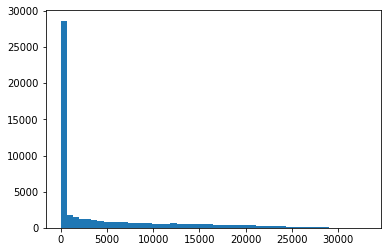

In [53]:
plt.hist(hourly_pv_de_df, bins = 50)

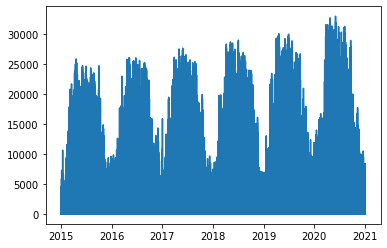

In [54]:
plt.plot(hourly_pv_de_df)

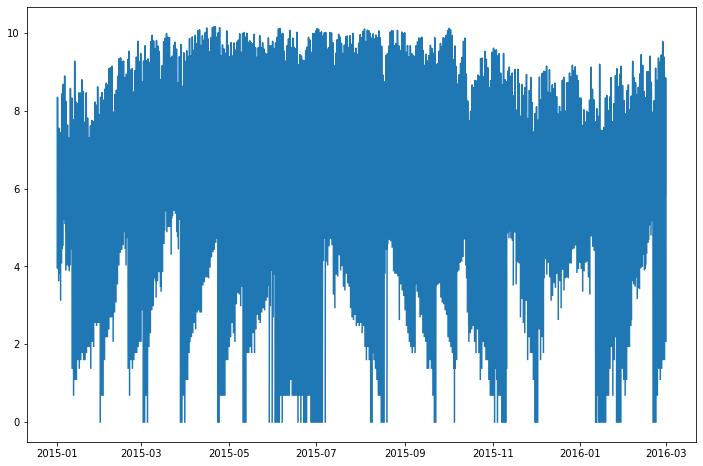

In [55]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(np.log(hourly_pv_de_df.loc[:dt.date(2016,3,1)]))

{'whiskers': [<matplotlib.lines.Line2D at 0x141441370>,
 'caps': [<matplotlib.lines.Line2D at 0x1414419d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14146df10>],
 'medians': [<matplotlib.lines.Line2D at 0x1413b6130>],
 'fliers': [<matplotlib.lines.Line2D at 0x1413b64c0>],
 'means': []}

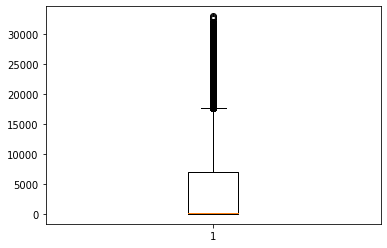

In [56]:
plt.boxplot(hourly_pv_de_df)

## Check for stationarity

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

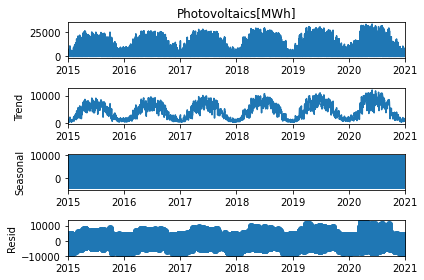

In [58]:
result_add = seasonal_decompose(hourly_pv_de_df['Photovoltaics[MWh]'], model='additive')
result_add.plot();

In [59]:
from statsmodels.tsa.stattools import adfuller

adfuller(hourly_pv_de_df['Photovoltaics[MWh]'])[1]

1.2281536192022685e-14

In [60]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])

additive resid:  0.0


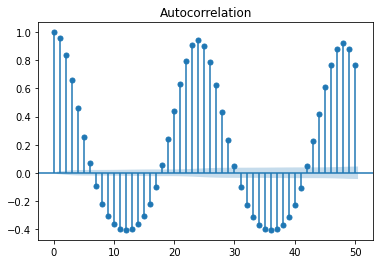

In [61]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(hourly_pv_de_df['Photovoltaics[MWh]'], lags=50)
plt.show()

In [62]:
y = hourly_pv_de_df['Photovoltaics[MWh]']

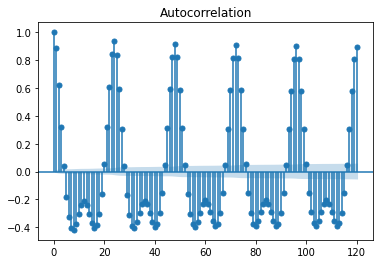

In [63]:
plot_acf(y.diff(1).dropna(), lags=120);

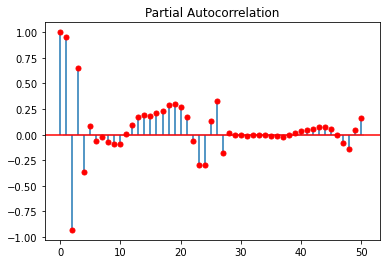

In [64]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(hourly_pv_de_df['Photovoltaics[MWh]'], lags=50, c='r')
plt.show()

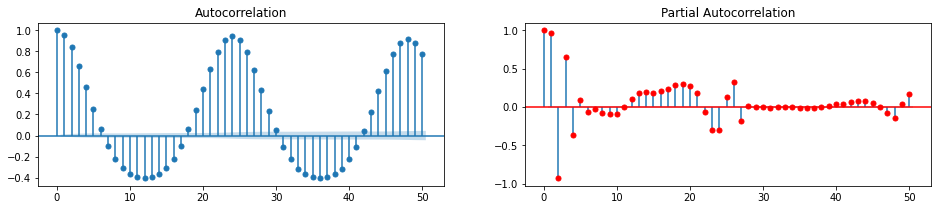

In [65]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(hourly_pv_de_df['Photovoltaics[MWh]'], lags=50, ax=axes[0]);
plot_pacf(hourly_pv_de_df['Photovoltaics[MWh]'], lags=50, ax=axes[1], color='r');

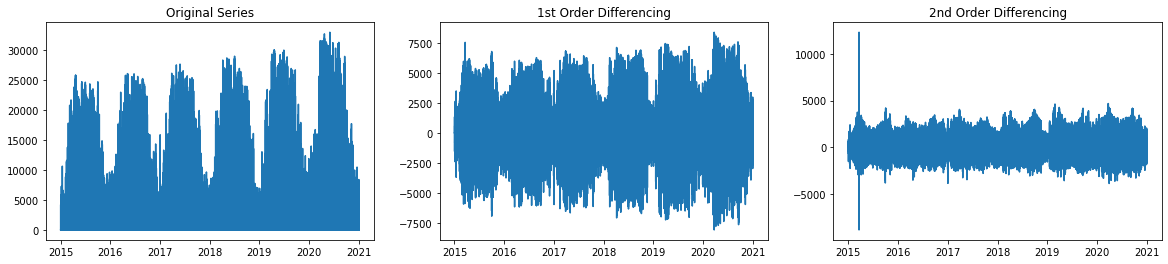

In [66]:
zero_diff = y
first_order_diff = y.diff(1)
second_order_diff = y.diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

## Building train/ test split

In [113]:
start_date = dt.datetime(2020,1,1) # incl.
end_date = dt.datetime(2021,1,2) # excl.

In [114]:
hourly_directradiation_df.head()

,164,183,198,232,282,342,427,430,433,460,...,6163,6197,7351,7367,7368,7369,7370,7374,13674,15000
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
hourly_globalradiation_df.head()

,164,183,198,232,282,342,427,430,433,460,...,6197,7351,7367,7368,7369,7370,7374,13674,15000,15818
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
print(hourly_globalradiation_df.shape)
print(hourly_humidity_df.shape)
print(hourly_directradiation_df.shape)
print(hourly_cloud_df.shape)
print(hourly_airp_df.shape)
print(hourly_temperature_df.shape)

(11664, 119)
(55488, 515)
(11664, 118)
(55488, 207)
(55488, 212)
(55488, 515)


In [117]:
pd.DataFrame(y).tail()

,Photovoltaics[MWh]
Date,
2021-01-01 19:00:00,0.0
2021-01-01 20:00:00,0.0
2021-01-01 21:00:00,0.0
2021-01-01 22:00:00,0.0
2021-01-01 23:00:00,0.0


In [118]:
y = pd.DataFrame(y)

In [119]:
y = y[(y.index >= start_date) & (y.index < end_date)]
y.shape

(8808, 1)

In [120]:
hourly_globalradiation_df = hourly_globalradiation_df[(hourly_globalradiation_df.index >= start_date) & (hourly_globalradiation_df.index < end_date)]
hourly_humidity_df = hourly_globalradiation_df[(hourly_globalradiation_df.index >= start_date) & (hourly_globalradiation_df.index < end_date)]
hourly_directradiation_df = hourly_globalradiation_df[(hourly_globalradiation_df.index >= start_date) & (hourly_globalradiation_df.index < end_date)]
hourly_cloud_df = hourly_globalradiation_df[(hourly_globalradiation_df.index >= start_date) & (hourly_globalradiation_df.index < end_date)]
hourly_airp_df = hourly_globalradiation_df[(hourly_globalradiation_df.index >= start_date) & (hourly_globalradiation_df.index < end_date)]
hourly_temperature_df = hourly_globalradiation_df[(hourly_globalradiation_df.index >= start_date) & (hourly_globalradiation_df.index < end_date)]

In [121]:
print(hourly_globalradiation_df.shape)
print(hourly_humidity_df.shape)
print(hourly_directradiation_df.shape)
print(hourly_cloud_df.shape)
print(hourly_airp_df.shape)
print(hourly_temperature_df.shape)

(8808, 119)
(8808, 119)
(8808, 119)
(8808, 119)
(8808, 119)
(8808, 119)


## Defining different feature sets

In [123]:
X1 = hourly_temperature_df

In [141]:
X2 = hourly_temperature_df.merge(hourly_directradiation_df, on = hourly_temperature_df.index)
X2.rename(columns={'key_0':'Date'},inplace=True)
X2.set_index('Date',inplace=True)
X2.head()

,164_x,183_x,198_x,232_x,282_x,342_x,427_x,430_x,433_x,460_x,...,6197_y,7351_y,7367_y,7368_y,7369_y,7370_y,7374_y,13674_y,15000_y,15818_y
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
X3 = X2.merge(hourly_globalradiation_df, on = hourly_temperature_df.index)                                                                    
X3.rename(columns={'key_0':'Date'},inplace=True)
X3.set_index('Date',inplace=True)
X3.head()

,164_x,183_x,198_x,232_x,282_x,342_x,427_x,430_x,433_x,460_x,...,6197,7351,7367,7368,7369,7370,7374,13674,15000,15818
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
X1.shape

(8808, 119)

In [144]:
X2.shape

(8808, 238)

In [145]:
X3.shape

(8808, 357)

In [156]:
X1.isna().sum()[X1.isna().sum()>0]

Series([], dtype: int64)

In [265]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.33, random_state=100)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.33, random_state=100)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.33, random_state=100)

In [147]:
y1_test.shape

(2907, 1)

In [148]:
X1_test.shape

(2907, 119)

In [149]:
X2_test.shape

(2907, 238)

In [150]:
X3_test.shape

(2907, 357)

# Correlation

In [226]:
y[y.iloc[:,0]!=0]

,Photovoltaics[MWh]
Date,
2020-01-01 08:00:00,376.0
2020-01-01 09:00:00,3111.0
2020-01-01 10:00:00,6772.0
2020-01-01 11:00:00,9711.0
2020-01-01 12:00:00,11069.0
...,...
2021-01-01 12:00:00,4829.0
2021-01-01 13:00:00,4235.0
2021-01-01 14:00:00,2728.0


In [225]:
y[y.iloc[:,0]==0]

,Photovoltaics[MWh]
Date,
2020-01-01 00:00:00,0.0
2020-01-01 01:00:00,0.0
2020-01-01 02:00:00,0.0
2020-01-01 03:00:00,0.0
2020-01-01 04:00:00,0.0
...,...
2021-01-01 19:00:00,0.0
2021-01-01 20:00:00,0.0
2021-01-01 21:00:00,0.0


In [191]:
df1 = y.merge(X1, on = y.index)
df1.set_index('key_0', inplace=True)
df1.head()

,Photovoltaics[MWh],164,183,198,232,282,342,427,430,433,...,6197,7351,7367,7368,7369,7370,7374,13674,15000,15818
key_0,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [193]:
df1.corr()

,Photovoltaics[MWh],164,183,198,232,282,342,427,430,433,...,6197,7351,7367,7368,7369,7370,7374,13674,15000,15818
Photovoltaics[MWh],1.000000,0.781904,0.784567,0.840052,0.833661,0.843732,0.804891,0.801436,0.798046,0.795662,...,0.830419,0.778451,0.804294,0.847282,0.313818,0.803807,0.845518,0.873762,0.864652,0.026959
164,0.781904,1.000000,0.905056,0.875812,0.839041,0.850845,0.832245,0.942004,0.947393,0.928034,...,0.860106,0.949290,0.850815,0.867720,0.260817,0.824641,0.852875,0.852414,0.847564,0.019928
183,0.784567,0.905056,1.000000,0.844641,0.814185,0.827109,0.814584,0.887386,0.892464,0.863146,...,0.848993,0.907656,0.822876,0.843471,0.228300,0.797496,0.844924,0.842024,0.838502,0.012037
198,0.840052,0.875812,0.844641,1.000000,0.866314,0.905808,0.855467,0.893434,0.895779,0.884342,...,0.906860,0.858403,0.890417,0.941802,0.295429,0.862398,0.876763,0.891792,0.884119,0.035882
232,0.833661,0.839041,0.814185,0.866314,1.000000,0.903048,0.795099,0.851481,0.847338,0.845515,...,0.840926,0.827016,0.813402,0.880569,0.329135,0.889958,0.834091,0.915523,0.848698,0.036501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7370,0.803807,0.824641,0.797496,0.862398,0.889958,0.899512,0.793500,0.840968,0.839285,0.842673,...,0.828568,0.804636,0.802130,0.871850,0.288948,1.000000,0.805431,0.879632,0.826566,0.036959
7374,0.845518,0.852875,0.844924,0.876763,0.834091,0.861827,0.889796,0.862144,0.863456,0.855068,...,0.908431,0.858096,0.869995,0.878520,0.274031,0.805431,1.000000,0.874941,0.914443,0.009671
13674,0.873762,0.852414,0.842024,0.891792,0.915523,0.927236,0.840249,0.869903,0.869367,0.866634,...,0.881994,0.848265,0.852444,0.914723,0.289871,0.879632,0.874941,1.000000,0.899384,0.034530
15000,0.864652,0.847564,0.838502,0.884119,0.848698,0.877987,0.867595,0.862401,0.858040,0.854476,...,0.906444,0.850591,0.877066,0.899515,0.258674,0.826566,0.914443,0.899384,1.000000,0.014791


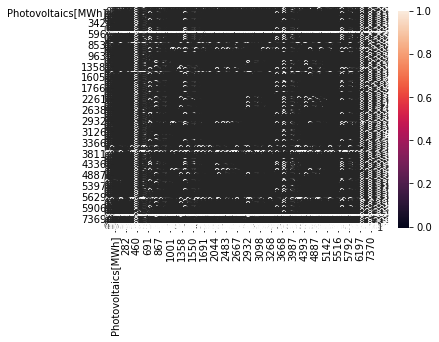

In [194]:
import seaborn as sns

corrMatrix = df1.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [195]:
corr_indices = corrMatrix['Photovoltaics[MWh]'][corrMatrix['Photovoltaics[MWh]']>0.7].index[1:]

In [196]:
corr_indices = list(corr_indices)
corr_indices

['164',
 '183',
 '198',
 '232',
 '282',
 '342',
 '427',
 '430',
 '433',
 '460',
 '591',
 '596',
 '662',
 '691',
 '701',
 '704',
 '853',
 '856',
 '867',
 '880',
 '891',
 '953',
 '963',
 '1001',
 '1048',
 '1078',
 '1270',
 '1346',
 '1358',
 '1443',
 '1468',
 '1503',
 '1544',
 '1550',
 '1605',
 '1612',
 '1639',
 '1684',
 '1691',
 '1757',
 '1766',
 '1975',
 '2014',
 '2044',
 '2115',
 '2171',
 '2261',
 '2290',
 '2483',
 '2485',
 '2559',
 '2601',
 '2638',
 '2667',
 '2712',
 '2812',
 '2907',
 '2925',
 '2932',
 '3015',
 '3028',
 '3032',
 '3086',
 '3098',
 '3126',
 '3167',
 '3196',
 '3231',
 '3268',
 '3287',
 '3366',
 '3631',
 '3660',
 '3668',
 '3730',
 '3761',
 '3811',
 '3946',
 '3987',
 '4104',
 '4177',
 '4271',
 '4336',
 '4393',
 '4466',
 '4625',
 '4642',
 '4745',
 '4887',
 '4911',
 '4928',
 '5100',
 '5109',
 '5142',
 '5397',
 '5404',
 '5426',
 '5480',
 '5516',
 '5546',
 '5629',
 '5705',
 '5779',
 '5792',
 '5839',
 '5856',
 '5906',
 '6163',
 '6197',
 '7351',
 '7367',
 '7368',
 '7370',
 '7374

In [197]:
X1_new = X1[corr_indices]
X1_new.head()

,164,183,198,232,282,342,427,430,433,460,...,5906,6163,6197,7351,7367,7368,7370,7374,13674,15000
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Defining loss functions

In [323]:
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops

def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_percentage_error_alt(y_true, y_pred):  # pylint: disable=missing-docstring
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    diff = math_ops.abs((y_true - y_pred) / K.clip(math_ops.abs(y_true), K.epsilon(), None))
    return 100. * K.mean(diff, axis=-1)

In [227]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]

# Regression models

## Linear regression model

In [268]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

def linear_regression(X, X_train, y, y_train):
    lr = LinearRegression()
    cv_results = cross_validate(lr, X, y, cv=10, scoring=('r2', 'neg_mean_absolute_percentage_error'))
    reg = LinearRegression().fit(X_train, y_train)
    score = reg.score(X_train, y_train)
    print(score)
    return score, cv_results, reg

In [269]:
score1, cv_results1, reg1 = linear_regression(X1, X1_train, y, y1_train)
score2, cv_results2, reg2 = linear_regression(X2, X2_train, y, y2_train)
score3, cv_results3, reg3 = linear_regression(X3, X3_train, y, y3_train)

0.8474724306714502
0.8474724715844522
0.8474724185502635


In [267]:
cv_results2

{'fit_time': array([0.07591295, 0.05429602, 0.05726004, 0.06911898, 0.05708098,
        0.05878401, 0.05849695, 0.05915213, 0.05875111, 0.06393719]),
 'score_time': array([0.00840712, 0.00838995, 0.00975585, 0.00888205, 0.00801301,
        0.00874209, 0.0095129 , 0.00991702, 0.00945878, 0.00883389]),
 'test_r2': array([0.83299916, 0.82685736, 0.84398496, 0.79784697, 0.75620118,
        0.78956877, 0.73398714, 0.74707615, 0.77140298, 0.70541035]),
 'test_neg_mean_absolute_percentage_error': array([-1.59591249e+18, -1.36164900e+18, -1.03503498e+18, -7.42647099e+17,
        -5.44891094e+17, -6.02771117e+17, -8.12366240e+17, -1.09565138e+18,
        -1.45010703e+18, -1.58176451e+18])}

In [270]:
y_pred2 = reg2.predict(X2_test)
y_pred2

array([[10066.343 ],
       [15630.922 ],
       [  530.499 ],
       ...,
       [ 1236.9236],
       [  676.1459],
       [  530.499 ]], dtype=float32)

In [316]:
ops.convert_to_tensor(y_pred2)

<tf.Tensor: shape=(2907, 1), dtype=float32, numpy=
array([[10066.343 ],
       [15630.922 ],
       [  530.499 ],
       ...,
       [ 1236.9236],
       [  676.1459],
       [  530.499 ]], dtype=float32)>

In [321]:
mean_absolute_percentage_error(y2_test,y_pred2)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

## XGboost

In [293]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [294]:
data_dmatrix = xgb.DMatrix(data=X1,label=y)

In [295]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [296]:
xg_reg.fit(X1_train,y1_train)

preds = xg_reg.predict(X1_test)

In [297]:
pd.DataFrame(preds)

,0
0,6456.092773
1,8895.054688
2,31.175629
3,31.175629
4,31.175629
...,...
2902,31.175629
2903,31.175629
2904,1402.291382
2905,1527.384888


In [298]:
y1_test

,Photovoltaics[MWh]
Date,
2020-07-19 17:00:00,13509.0
2020-06-21 06:00:00,1964.0
2020-03-29 03:00:00,0.0
2020-10-03 03:00:00,0.0
2020-04-03 20:00:00,1.0
...,...
2020-02-02 04:00:00,0.0
2020-03-06 03:00:00,0.0
2020-12-02 13:00:00,3281.0


In [299]:
rmse = np.sqrt(mean_squared_error(y1_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 4430.931584


In [300]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [301]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,8661.219076,50.557572,8674.850586,94.887101
1,7926.900391,44.485875,7956.695801,81.821866
2,7270.565104,44.684504,7319.670736,63.663304
3,6685.819499,40.312434,6752.382487,54.707726
4,6160.008626,35.368729,6246.678548,43.478464


In [302]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

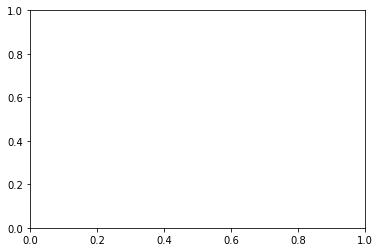

In [303]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

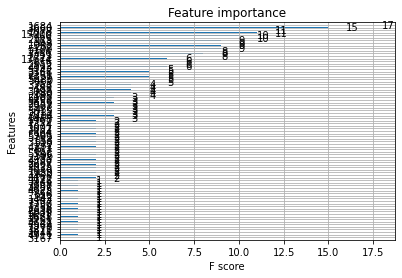

In [304]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [160, 16]
plt.show()

In [322]:
mean_absolute_percentage_error(y1_test,preds)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

# Time series model

In [335]:
y.shape

(8808, 1)

In [341]:
y_ts_train = pd.DataFrame(y.iloc[:round(y.shape[0]*.9),])
y_ts_test = pd.DataFrame(y.iloc[round(y.shape[0]*.9):,])
X1_ts_train = pd.DataFrame(X1.iloc[:round(y.shape[0]*.9),])
X1_ts_test = pd.DataFrame(X1.iloc[round(y.shape[0]*.9):,])

In [342]:
y_ts_train.shape

(7927, 1)

In [343]:
y_ts_test.shape

(881, 1)

In [344]:
X1_ts_train.shape

(7927, 119)

In [345]:
X1_ts_test.shape

(881, 119)

## SARIMAX model

In [348]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

### Plot forecast function

In [ ]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

### Run auto-ARIMA

In [350]:
smodel = pm.auto_arima(y_ts_train, m=12, X=X1_ts_train,
                       start_p=0, max_p=2,
                       start_q=0, max_q=2,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=321.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=151004.439, Time=111.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=138713.238, Time=431.23 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=144171.838, Time=319.01 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=214403.460, Time=3.66 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=138073.435, Time=120.31 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=138787.190, Time=325.07 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=390.41 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=134179.653, Time=127.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=134566.160, Time=400.28 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=134749.460, Time=377.13 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=387.51 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=134051.768, Time=140.59 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=134008.760, Ti

/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,1)(2,0,0)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy

 ARIMA(2,0,1)(2,0,0)[12]             : AIC=inf, Time=nan sec

Best model:  ARIMA(2,0,1)(2,0,0)[12] intercept
Total fit time: 18896.427 seconds


In [351]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 7927
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 12)   Log Likelihood              -66577.624
Date:                             Sat, 05 Jun 2021   AIC                         133407.248
Time:                                     21:52:54   BIC                         134286.480
Sample:                                 01-01-2020   HQIC                        133708.333
                                      - 11-26-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     93.0583    149.434      0.623      0.533    -199.828     385.944
164           -0.0197      1.375     -0.014      0.989      -2.715       2.676
183           -0.3938      1.562     -0.252      0.801      -3.456       2.668
198            0.2476      1.436      0.172      0.863      -2.567       3.063
232           -0.2441      1.369     -0.178      0.859      -2.928       2.439
282            0.4299      1.457      0.295      0.768      -2.427       3.286
342           -0.1990      1.550     -0.128      0.898      -3.238       2.840
427           -0.3925      1.610     -0.244      0.807      -3.548       2.763
430           -0.0059      1.676     -0.004      0.997      -3.290       3.278
433            0.1190      1.642      0.072      0.942      -3.100       3.338
460            0.0965      1.509      0.064      0.949      -2.862       3.055
591            0.5610      1.365      0.411      0.681      -2.114       3.236
596           -0.1995      1.473     -0.135      0.892      -3.087       2.688
656            7.2682      2.482      2.928      0.003       2.403      12.133
662            0.0584      1.374      0.042      0.966      -2.635       2.752
691           -0.0398      1.409     -0.028      0.977      -2.801       2.722
701           -0.3199      1.467     -0.218      0.827      -3.194       2.555
704            0.1605      1.547      0.104      0.917      -2.873       3.194
853            0.1033      1.486      0.070      0.945      -2.809       3.015
856            0.5248      1.538      0.341      0.733      -2.490       3.539
867            0.1130      1.484      0.076      0.939      -2.796       3.022
880           -0.0169      1.402     -0.012      0.990      -2.764       2.730
891           -0.1413      1.520     -0.093      0.926      -3.121       2.838
953            0.1930      1.420      0.136      0.892      -2.589       2.975
963            0.4317      1.425      0.303      0.762      -2.362       3.226
1001           0.7108      1.438      0.494      0.621      -2.108       3.530
1048           0.0693      1.365      0.051      0.959      -2.606       2.744
1078          -0.2461      1.501     -0.164      0.870      -3.189       2.696
1270           0.4021      1.324      0.304      0.761      -2.192       2.996
1346          -0.2360      1.392     -0.170      0.865      -2.964       2.492
1358           0.1962      1.272      0.154      0.877      -2.296       2.689
1443           0.0015      1.474      0.001      0.999      -2.888       2.891
1468           0.6547      1.486      0.441      0.659      -2.257       3.567
1503           0.3447      1.445      0.239      0.811      -2.487       3.176
1544           0.3899      1.540      0.253      0.800      -2.629       3.409
1550           0.1732      1.383      0.125      0.900      -2.538       2.884
1605           0.3966      1.461      0.271

In [359]:
y_ts_train.shape

(7927, 1)

In [362]:
X1_ts_train.to_numpy().shape

(7927, 119)

In [363]:
sarimax = SARIMAX(endog=y_ts_train,exog=X1_ts_train,order=(2,0,1),seasonal=(2,0,0,12),alpha=0.05).fit()


/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [364]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Photovoltaics[MWh]   No. Observations:                 7927
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -66896.091
Date:                Sat, 05 Jun 2021   AIC                         134038.183
Time:                        21:58:58   BIC                         134896.480
Sample:                    01-01-2020   HQIC                        134332.099
                         - 11-26-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
164            0.0731      0.992      0.074      0.941      -1.871       2.017
183            0.4529      1.132      0.400      0.689      -1.765       2.671
198           -0.0932      1.066     -0.087      0.930      -2.182       1.996
232           -0.0941      0.995     -0.095      0.925      -2.044       1.856
282            0.5529      0.986      0.561      0.575      -1.379       2.485
342           -0.2501      1.055     -0.237      0.813      -2.318       1.818
427            0.1427      1.111      0.129      0.898      -2.034       2.319
430           -0.0338      1.166     -0.029      0.977      -2.319       2.251
433            0.0070      1.164      0.006      0.995      -2.275       2.289
460           -0.0709      1.104     -0.064      0.949      -2.235       2.093
591            0.6461      1.012      0.638      0.523      -1.338       2.631
596            0.2856      1.061      0.269      0.788      -1.793       2.365
656           -2.2691      2.246     -1.010      0.312      -6.671       2.132
662            0.2355      1.020      0.231      0.817      -1.763       2.234
691            0.3929      1.025      0.383      0.701      -1.615       2.401
701            0.0264      1.030      0.026      0.980      -1.992       2.045
704           -0.3221      1.073     -0.300      0.764      -2.425       1.780
853            0.0608      1.069      0.057      0.955      -2.034       2.156
856            0.2417      1.022      0.237      0.813      -1.760       2.244
867            0.2125      1.006      0.211      0.833      -1.759       2.184
880            0.5523      1.057      0.523      0.601      -1.519       2.623
891            0.2088      1.007      0.207      0.836      -1.765       2.183
953            0.5946      0.991      0.600      0.548      -1.347       2.536
963            0.2731      1.008      0.271      0.786      -1.702       2.248
1001          -0.0250      1.063     -0.024      0.981      -2.108       2.058
1048           0.5480      0.974      0.563      0.574      -1.360       2.456
1078           0.2460      1.045      0.235      0.814      -1.803       2.295
1270           0.5910      0.935      0.632      0.527      -1.242       2.424
1346          -0.3799      1.042     -0.364      0.716      -2.423       1.663
1358           0.0496      0.908      0.055      0.956      -1.730       1.829
1443           0.3073      1.086      0.283      0.777      -1.822       2.437
1468           0.4780      1.018      0.469      0.639      -1.518       2.474
1503           0.1907      1.043      0.183      0.855      -1.854       2.235
1544           0.0422      1.040      0.041      0.968      -1.996       2.080
1550           0.5853      1.048      0.559      0.576      -1.468       2.638
1605           0.3241      0.992      0.327      0.744      -1.620       2.268
1612           0.1230      1.039      0.118      0.906      -1.914       2.160
1639           0.6977      0.942      0.740      0.459      -1.149       2.545
16

In [368]:
forecast = sarimax.forecast(len(y_ts_test), exog=X1_ts_test, alpha=0.05)

In [369]:
forecast

2020-11-26 07:00:00    9.959503e+01
2020-11-26 08:00:00    4.826698e+02
2020-11-26 09:00:00    9.379038e+02
2020-11-26 10:00:00    1.349375e+03
2020-11-26 11:00:00    1.468894e+03
                           ...     
2021-01-01 19:00:00    9.407782e-34
2021-01-01 20:00:00    1.382364e-33
2021-01-01 21:00:00    1.660169e-33
2021-01-01 22:00:00    1.782539e-33
2021-01-01 23:00:00    1.766760e-33
Freq: H, Name: predicted_mean, Length: 881, dtype: float64

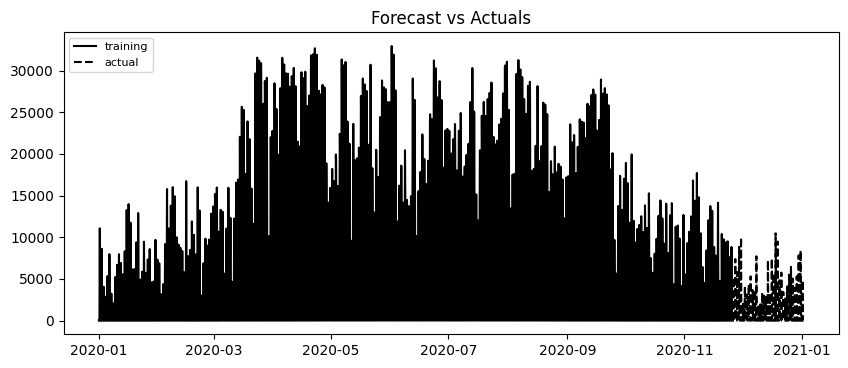

In [367]:
plot_forecast(forecast, y_ts_train, y_ts_test)

In [372]:
mean_absolute_percentage_error(forecast,y_ts_test)

1.589161317018297e+36

### Another auto-ARIMA

In [375]:
X1 = X1.mean(axis=1)
X1.head()

Date
2020-01-01 00:00:00    0.0
2020-01-01 01:00:00    0.0
2020-01-01 02:00:00    0.0
2020-01-01 03:00:00    0.0
2020-01-01 04:00:00    0.0
dtype: float32

In [377]:
X1_ts_train = pd.DataFrame(X1.iloc[:round(y.shape[0]*.9),])
X1_ts_test = pd.DataFrame(X1.iloc[round(y.shape[0]*.9):,])

In [378]:
smodel = pm.auto_arima(y_ts_train, m=12, X=X1_ts_train,
                       start_p=0, max_p=2,
                       start_q=0, max_q=2,
                       max_P=2, max_D=1,max_Q=2,
                       seasonal=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=7.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=153406.480, Time=0.19 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=138873.513, Time=4.77 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=143381.889, Time=7.20 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=216764.095, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=139104.168, Time=1.29 sec


/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,0)(2,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py", line 506, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 482, in fit
    self._fit(y, X, **fit_args)
  File "/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/pmdarima/arima/arima.py", line 403, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy

 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=14.84 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=139030.624, Time=4.36 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=125514.869, Time=55.23 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=13.19 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=134418.809, Time=35.66 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=137058.501, Time=41.89 sec
 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=16.000, Time=49.44 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=13.82 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=94.89 sec
 ARIMA(2,0,0)(2,0,2)[12] intercept   : AIC=123072.295, Time=88.41 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=127854.528, Time=13.03 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=125546.428, Time=41.15 sec
 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=119093.327, Time=68.41 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=128363.794, Time=36

In [379]:
smodel.summary()

/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:2937: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:3108: RuntimeWarning: invalid value encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 7927
Model:             SARIMAX(2, 0, 0)x(2, 0, [1], 12)   Log Likelihood                   0.000
Date:                              Sat, 05 Jun 2021   AIC                             16.000
Time:                                      22:17:42   BIC                             71.824
Sample:                                  01-01-2020   HQIC                            35.116
                                       - 11-26-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     68.9378         -0       -inf      0.000      68.938      68.938
0              7.1206         -0       -inf      0.000       7.121       7.121
ar.L1          1.7681         -0       -inf      0.000       1.768       1.768
ar.L2         -0.8203   1.15e-11  -7.12e+10      0.000      -0.820      -0.820
ar.S.L12       0.0008         -0       -inf      0.000       0.001       0.001
ar.S.L24       0.9992         -0       -inf      0.000       0.999       0.999
ma.S.L12       0.6678         -0       -inf      0.000       0.668       0.668
sigma2      2.374e+05         -0       -inf      0.000    2.37e+05    2.37e+05
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):              2972.62
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):                nan   Skew:                             0.00
Prob(H) (two-sided):                   nan   Kurtosis:                         0.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [381]:
sarimax = SARIMAX(endog=y_ts_train,exog=X1_ts_train,order=(2,0,0),seasonal=(2,0,1,12),alpha=0.05).fit()

/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/michael.kuntz/.pyenv/versions/lewagon/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [382]:
forecast = sarimax.forecast(len(y_ts_test), exog=X1_ts_test, alpha=0.05)

In [385]:
forecast

2020-11-26 07:00:00    3.749751e+02
2020-11-26 08:00:00    1.575492e+03
2020-11-26 09:00:00    2.764246e+03
2020-11-26 10:00:00    3.713916e+03
2020-11-26 11:00:00    3.937263e+03
                           ...     
2021-01-01 19:00:00    1.502364e-32
2021-01-01 20:00:00    8.791592e-32
2021-01-01 21:00:00    1.385242e-31
2021-01-01 22:00:00    1.639506e-31
2021-01-01 23:00:00    1.649011e-31
Freq: H, Name: predicted_mean, Length: 881, dtype: float64

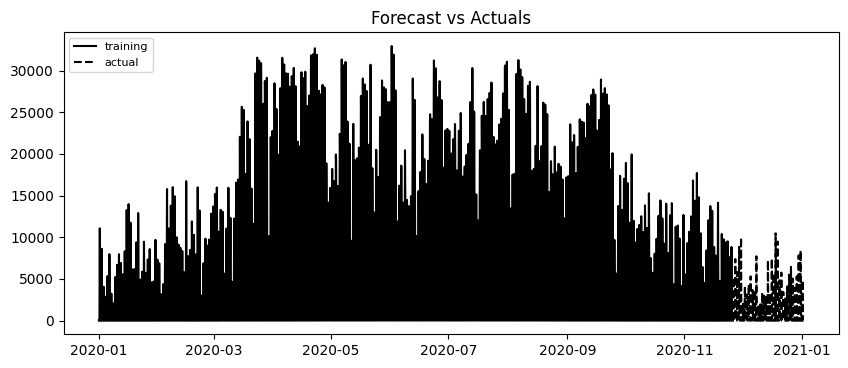

In [383]:
plot_forecast(forecast, y_ts_train, y_ts_test)

In [384]:
mean_absolute_percentage_error(forecast,y_ts_test)

1.694747272065438e+34